In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl

import hsilib as hl
hl = reload(hl)

from pathlib import Path

In [3]:
def get_rayleigh_scattering(HSI):
    rayleigh_sig = np.zeros(shape = bands, dtype = HSI.dtype)
    for i in range(bands):
        layer = HSI[..., i]
        rayleigh_sig[i] = layer[layer > 0].min()
        
    return rayleigh_sig

In [4]:
def cv2_save(image, path):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    result = cv2.imwrite(path, image)
    return result

753 1924 63


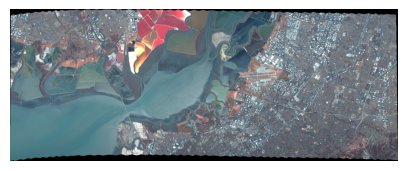

In [5]:
import spectral.io.envi as envi
hsi_path = r'C:\Users\konst\jupyter_notebook\HSI\data envil\moffet\\'
moffett_hsi = envi.open(hsi_path + r'f080611t01p00r07rdn_c_sc01_ort_img.hdr',
                        hsi_path + r'f080611t01p00r07rdn_c_sc01_ort_img')

HSI = np.array(np.rot90(moffett_hsi.open_memmap(writble = True)), dtype = np.float32)

#HSI = np.concatenate((HSI[..., :94], HSI[..., 131:]), axis = 2)
HSI = HSI[..., :63]

height, width, bands = HSI.shape

color_image = hl.HSI_to_RGB(HSI, (37, 18, 11))
print(height, width, bands)
hl.show(color_image, figsize = (5, 5))

In [6]:
rayleigh_scattering = get_rayleigh_scattering(HSI)
HSI -= rayleigh_scattering
HSI[HSI < 0] = 0

In [7]:
reference_coords = np.array(((540,  470),  #0  water
                             (288,  758),  #1  dirt
                             (154,  834),  #2  swamps
                             (315, 1334),  #3  soil
                             (335, 1360),  #4  vegetable
                             (305, 1280),  #5  concrete
                             (278,  606),  #6  salt
                             (18,   811),  #7  salt_water
                             (365, 1431),  #8  asphalt
                             (183, 1208),  #9  lake
                             (707, 1810),  #10 clay
                             (241, 1299),  #11 roof
                             (427, 774),   #12 water2
                             (59, 1098),   #13 lake 2
                             (142, 704),   #14 salt 2
                             (93, 1137)),  #15 swamps 2
                             dtype = int)

name_reference = ("water", "dirt", "swamps", "soil", "vegetable", "concrete", "salt", "salt_water")
name_reference_ru = ("вода", "загрязнения", "болота 1", "грунт", "растительность", "бетон", "соляной пруд 1", "соляной пруд 2", "асфальт", "озёра 1", "деревья", "крыши", "мелководья", "озёра 2", "соляной пруд 3", 'болота 2')

colors_class = np.array(((0.16, 0.56, 0.56), (0.64, 0.28, 0.64), (0.05, 0.54, 0.13),
                         (0.72, 0.45, 0.2), (0, 0.9, 0), (0.75, 0.75, 0.75),
                         (1, 1, 0), (1, 0, 0), (0.3, 0.3, 0.3),
                         (0.6, 0.35, 0.35), (1, 0.46, 0.22), (0.95, 0.95, 1),
                         (0.26, 0.70, 0.70), (0.2, 0.2, 0.4), (0.4, 0.1, 0.1),
                         (0.2, 0.4, 0.2)))

In [62]:
reference_coords = np.array(((540,  470),  #0  water
                             (288,  758),  #1  dirt
                             (154,  834),  #2  swamps
                             (315, 1334),  #3  soil
                             (335, 1360),  #4  vegetable
                             (305, 1280),  #5  concrete
                             (278,  606),  #6  salt
                             (18,   811),  #7  salt_water
                             (365, 1431),  #8  asphalt
                             (183, 1208)),  #9  lake
                             dtype = int)

name_reference_ru = ("вода", "загрязнения", "болота 1", "грунт", "растительность", "бетон", "соляной пруд 1", "соляной пруд 2", "асфальт", "озёра 1")

colors_class = np.array(((0.16, 0.56, 0.56), (0.64, 0.28, 0.64), (0.05, 0.54, 0.13),
                         (0.72, 0.45, 0.2), (0, 0.9, 0), (0.75, 0.75, 0.75),
                         (1, 1, 0), (1, 0, 0), (0.1, 0.1, 1),
                         (0.3, 0.3, 0.3)))

In [8]:
hsi_reference = hl.calc_ref(reference_coords, HSI, 1)

In [9]:
imf_reference = hl.EMD(hsi_reference, 4)

обработано 16 пикселей из 16

In [17]:
def ANGLE(vector1, vector2):
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)

    #return np.dot(unit_vector1, unit_vector2)
    return np.abs(np.dot(unit_vector1, unit_vector2) - 1)

def mul_cos_angles(matrix, vector):
    unit_vector = vector / np.linalg.norm(vector)
    dot = np.zeros(shape = matrix.shape[:2])
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            
            norm = np.linalg.norm(matrix[i, j])
            if norm != 0:
                unit_matrix = matrix[i, j] / np.linalg.norm(matrix[i, j])
                dot[i, j] = np.dot(unit_matrix, unit_vector)
                
    return np.abs(dot - 1)

def EVKLID(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

In [18]:
def do_corr_matrix(vector, metric):
    len_vec = vector.shape[0]
    
    corr_matrix = np.zeros(shape = (len_vec, len_vec), dtype = float)
    
    for j in range(len_vec):
        for k in range(len_vec):
            if j > k:
                continue
            
            correlation = metric(vector[j], vector[k])
            
            corr_matrix[j, k] = correlation
            corr_matrix[k, j] = correlation
            
    return corr_matrix

def show_corr_matrix(corr_matrix, label_axis, title, path = None):    
    fig, ax = plt.subplots(figsize = (7, 7))
    im = ax.imshow(corr_matrix)

    ax.set_xticks(np.arange(len(label_axis)), labels=label_axis, fontsize = 12)
    ax.set_yticks(np.arange(len(label_axis)), labels=label_axis, fontsize = 12)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    for i in range(len(label_axis)):
        for j in range(len(label_axis)):
            #text = ax.text(j, i, int(corr_matrix[i, j]), ha="center", va="center", color="w", fontsize = 14)
            
            if i == j:
                text = ax.text(j, i, 0, ha="center", va="center", color="w", fontsize = 14)
            else:
                rad = np.arccos(1 - corr_matrix[i, j])
                ang = rad / (np.pi / 180)
                text = ax.text(j, i, int(ang), ha="center", va="center", color="w", fontsize = 14)
    
    #ax.set_title(title, fontsize = 16)
    fig.tight_layout()
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close()

In [12]:
s1 = imf_reference[0].copy()
s2 = imf_reference[2].copy()

norm_s2 = np.zeros(shape = s2.shape, dtype = float)
norm_value_s2 = np.linalg.norm(s1, axis = 1) / np.linalg.norm(s2, axis = 1)

for i in range(s1.shape[0]):
    norm_s2[i] = s2[i] * norm_value_s2[i]

compose_reference = np.concatenate((s1, norm_s2), axis = 1)
compose_reference.shape

(16, 126)

In [126]:
s1 = imf_reference[0].copy()
s2 = imf_reference[2].copy()
s3 = imf_reference[3].copy()

norm_s2 = np.zeros(shape = s2.shape, dtype = float)
norm_s3 = np.zeros(shape = s3.shape, dtype = float)

norm_value_s2 = np.linalg.norm(s1, axis = 1) / np.linalg.norm(s2, axis = 1)
norm_value_s3 = np.linalg.norm(s1, axis = 1) / np.linalg.norm(s3, axis = 1)

for i in range(s1.shape[0]):
    norm_s2[i] = s2[i] * norm_value_s2[i]
    norm_s3[i] = s3[i] * norm_value_s3[i]

compose_reference = np.concatenate((s1, norm_s2, norm_s3), axis = 1)
compose_reference.shape

(16, 561)

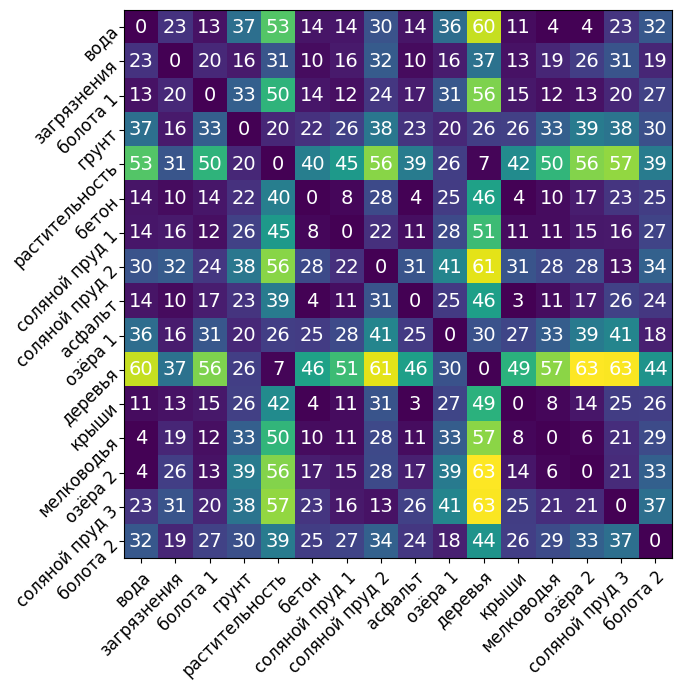

In [19]:
corr_matrix = do_corr_matrix(hsi_reference, ANGLE)
show_corr_matrix(corr_matrix, name_reference_ru, '')

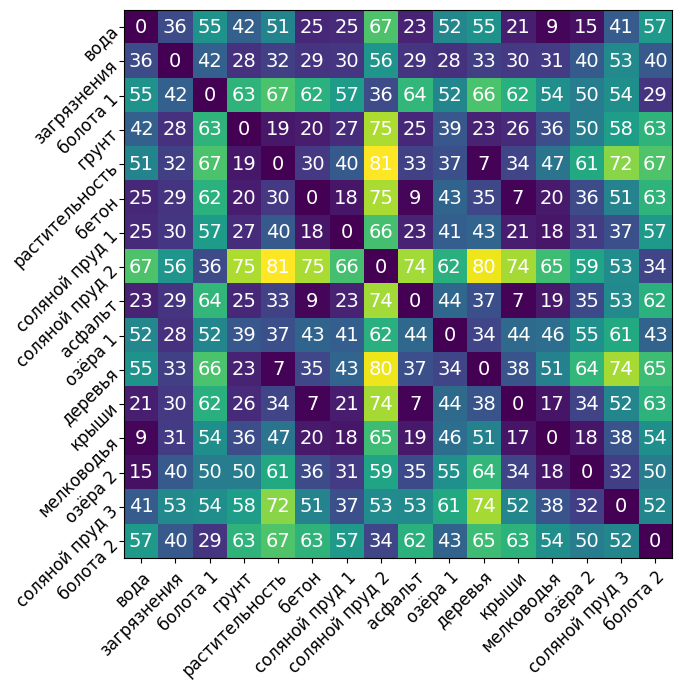

In [21]:
corr_matrix = do_corr_matrix(compose_reference, ANGLE)
show_corr_matrix(corr_matrix, name_reference_ru, '')

In [57]:
def do_clust_lite(imf_reference, name_reference, path):
    main_num_classes = imf_reference.shape[0]
    num_class_power = -1
    
#############################################################
    class_stat = dict()
    for i in range(len(name_reference)):
        class_stat[name_reference[i]] = [main_num_classes - 1, 0, 0]
        
#################################################################    
    for nc in range(main_num_classes - 1):
        tmp = 0
        max_class_power = 0
        num_class_power = -1
        num_classes, _ = imf_reference.shape
        correlation_inside = 0
#################################################################
            
        if num_classes > 2:
            #corr_matrix = do_corr_matrix(imf_reference, EVKLID)
            corr_matrix = do_corr_matrix(imf_reference, ANGLE)
            
            for k in range(num_classes):
                other_modul = 0.0
                
                for j in range(num_classes):
                    if j == k:
                        continue
                    other_stat_class = np.delete(corr_matrix[j], (k, j))
                    other_stat_class = other_stat_class.mean()
                    other_modul = other_modul + other_stat_class ** 2
                    
                
                class_power = np.sqrt(np.sum(corr_matrix[k] ** 2)) / np.sqrt(other_modul)
                if class_power > max_class_power:
                    max_class_power = class_power
                    num_class_power = k
                    tmp = corr_matrix[k]
                    correlation_inside = np.sqrt(np.sum(corr_matrix[k] ** 2))
                    
            
            class_stat[name_reference[num_class_power]][0] = nc
            class_stat[name_reference[num_class_power]][1] = correlation_inside
            class_stat[name_reference[num_class_power]][2] = np.min(tmp[tmp != 0])
                        
        else:
            #corr_two_classes = EVKLID(imf_reference[0], imf_reference[1])
            corr_two_classes = ANGLE(imf_reference[0], imf_reference[1])
            corr_matrix = np.array(((0, corr_two_classes), (corr_two_classes, 0)), dtype = float)
            
            class_stat[name_reference[num_class_power]][0] = nc
            class_stat[name_reference[num_class_power]][1] = corr_two_classes
            class_stat[name_reference[num_class_power]][2] = corr_two_classes
            
            class_stat[name_reference[num_class_power + 1]][0] = main_num_classes - 1
            class_stat[name_reference[num_class_power + 1]][1] = corr_two_classes
            class_stat[name_reference[num_class_power + 1]][2] = corr_two_classes
        
        print("\nclass_power", max_class_power, name_reference[num_class_power])
        
        if path is None:
            show_corr_matrix(corr_matrix, name_reference, "наисельнейший класс - " + name_reference[num_class_power])
        else:
            corr_path = path + '/cross-correlation-matrices/' + str(nc + 1) + "-" + name_reference[num_class_power] + "-cp-" + str(max_class_power)[:6] + ".png"
            show_corr_matrix(corr_matrix, name_reference, "наисельнейший класс - " + name_reference[num_class_power], corr_path)
    
        imf_reference = np.delete(imf_reference, num_class_power, axis = 0)
        name_reference = np.delete(name_reference, num_class_power)
    return class_stat


class_power 2.162794366069092 деревья


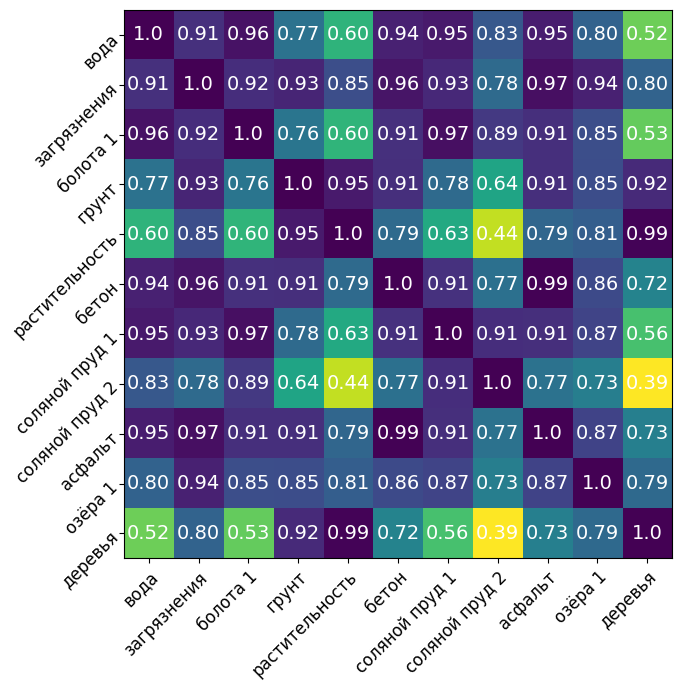


class_power 2.493805597248289 растительность


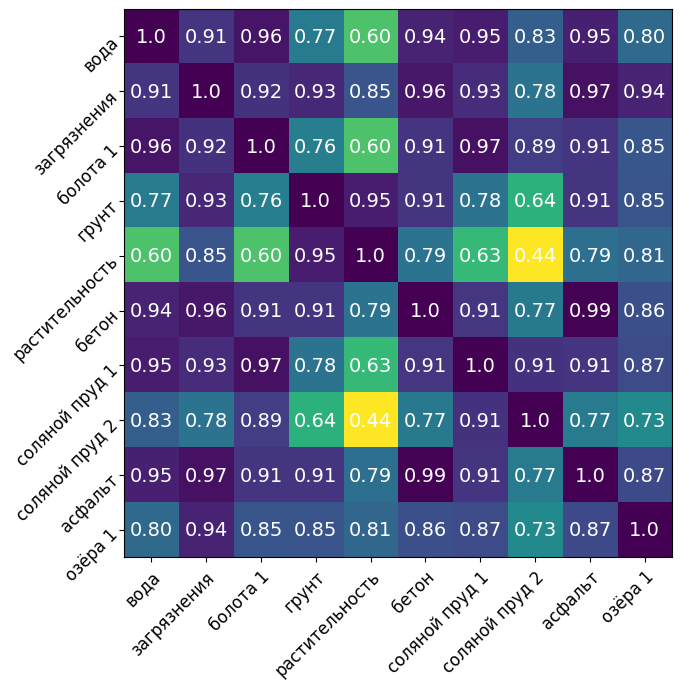


class_power 2.2040567863538687 соляной пруд 2


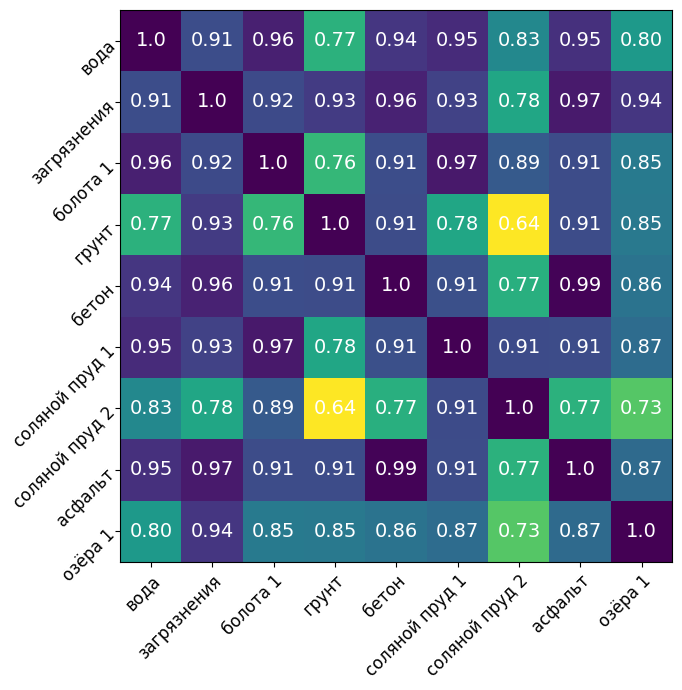


class_power 2.0609268762129824 грунт


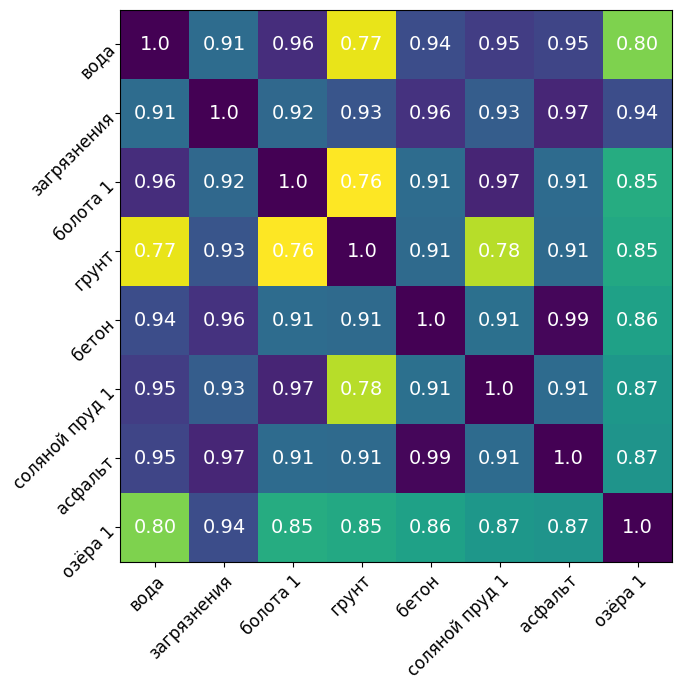


class_power 2.420847449871145 озёра 1


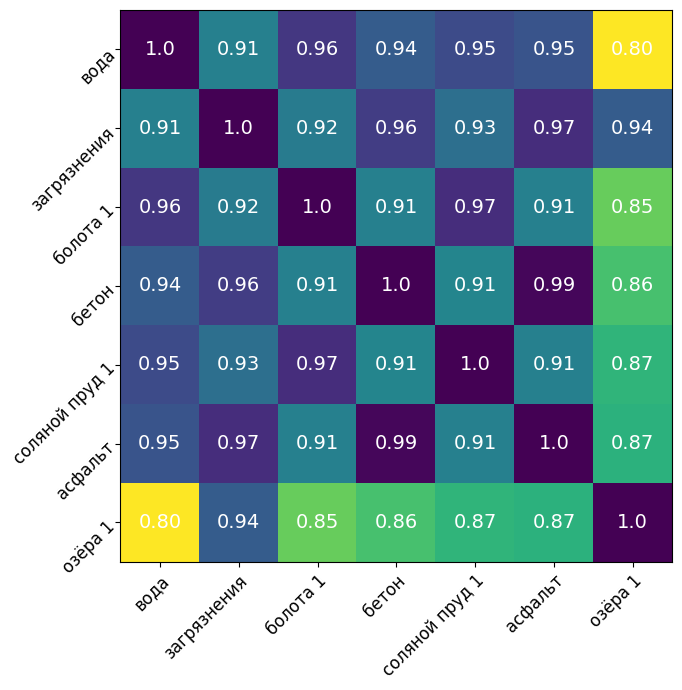


class_power 1.229191068421515 соляной пруд 1


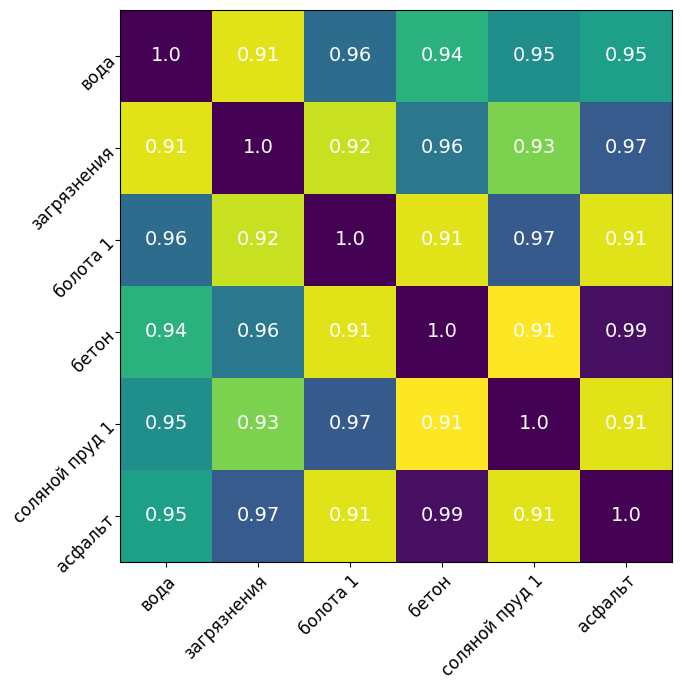


class_power 1.638366512837495 болота 1


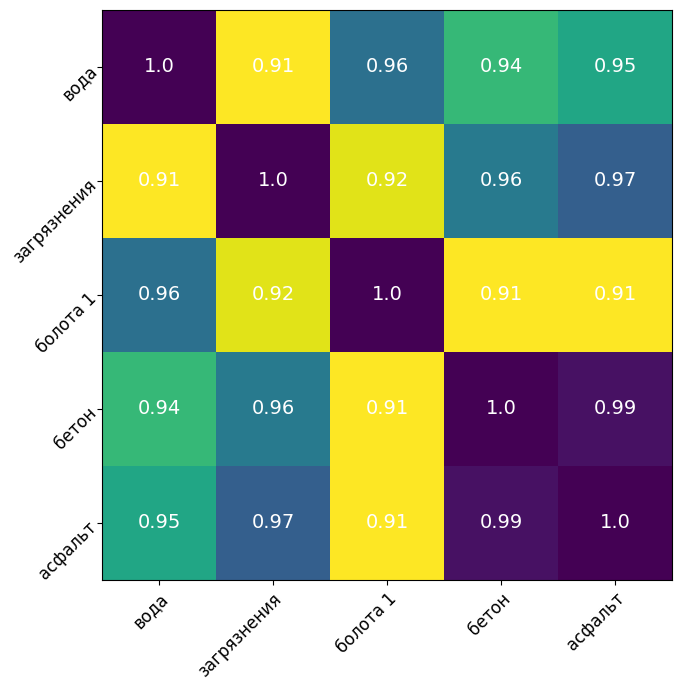


class_power 2.928397269966059 вода


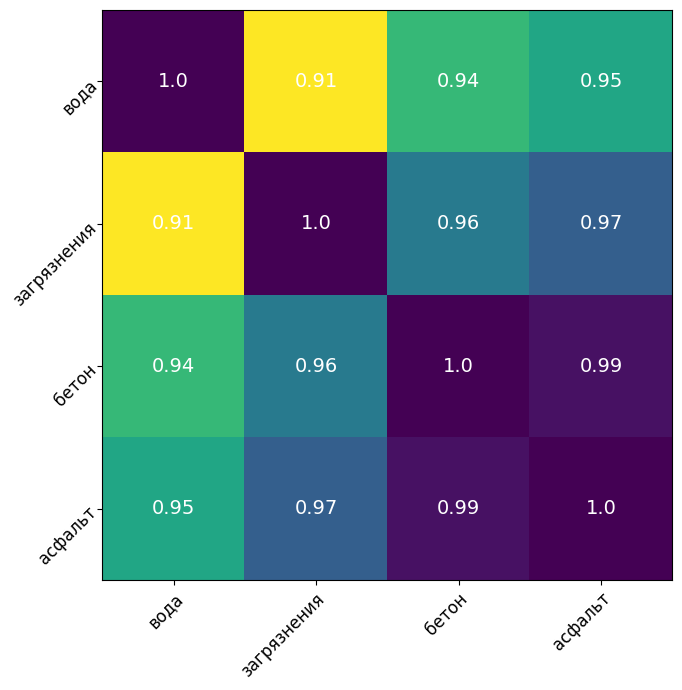


class_power 8.105031841788094 загрязнения


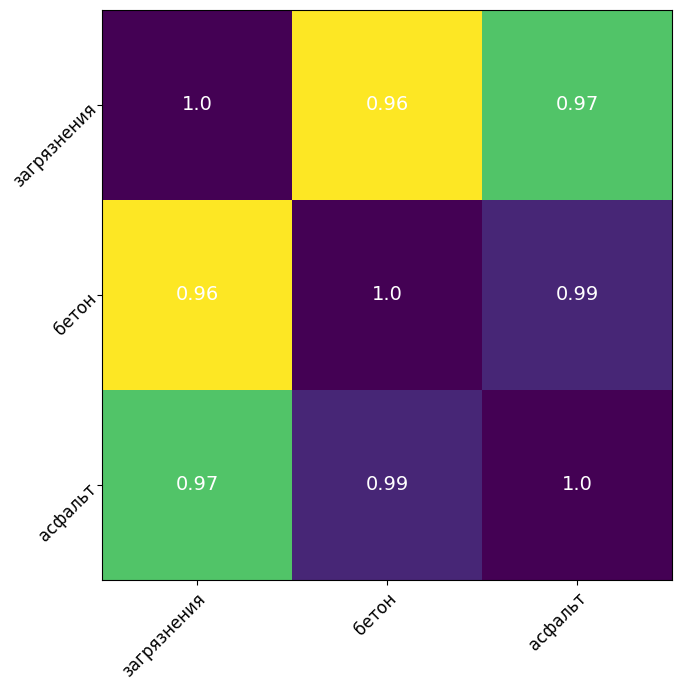


class_power 0 асфальт


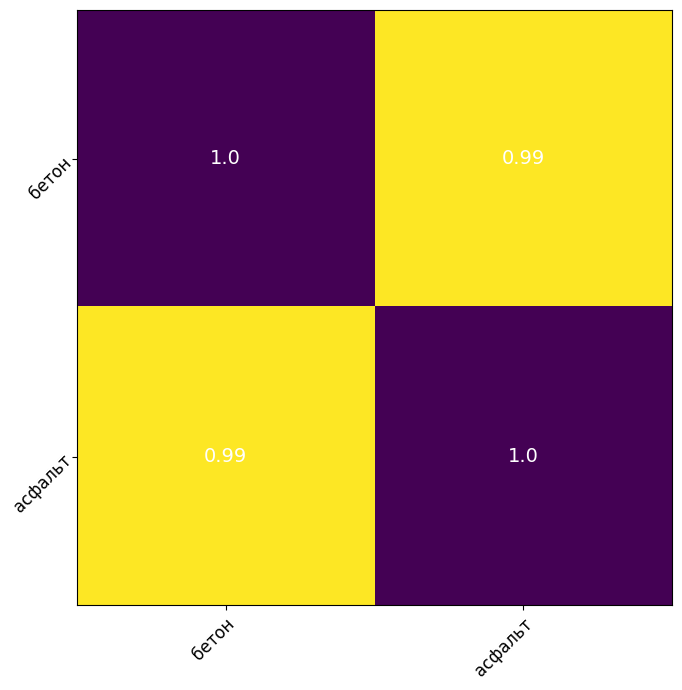

{'вода': [7, 0.11185652564579442, 0.04939886373810032],
 'загрязнения': [8, 0.04263676423503698, 2.220446049250313e-16],
 'болота 1': [6, 0.14549184697535716, 1.1102230246251565e-16],
 'грунт': [3, 0.43655488536413184, 0.06209962228319976],
 'растительность': [1, 0.9465126434001231, 2.220446049250313e-16],
 'бетон': [10, 0.0037197565298886515, 0.0037197565298886515],
 'соляной пруд 1': [5, 0.14799983551929252, 2.220446049250313e-16],
 'соляной пруд 2': [2, 0.6212787820359564, 2.220446049250313e-16],
 'асфальт': [9, 0.0037197565298886515, 0.0037197565298886515],
 'озёра 1': [4, 0.3321283023991432, 0.05556883800496393],
 'деревья': [0, 1.1083879797338643, 0.005582065276809489]}

In [58]:
do_clust_lite(hsi_reference, name_reference_ru, None)

In [134]:
compose_reference.shape

(16, 561)